# Estimate CNN Models

In [41]:
#TODO:
#* Lets have forcnn be training and nocnn be validation. No need for separate test set. Hmmmm no., wont have all classes.
#*In prepping, may want to ensure balance within (a) train and (b) validation

# Functions up top, then parameters / for loop below (some stuff doesn't need to be repeated for the for loop)

Adapted from:

https://codelabs.developers.google.com/codelabs/keras-flowers-transfer-learning#0

https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/04_Keras_Flowers_transfer_learning_solution.ipynb#scrollTo=M3G-2aUBQJ-H

## Setup

In [61]:
## Satellite and survey params
SURVEY_NAME = 'DHS'

SATELLITE         = 's2' #s2, landsat
OUTCOME_VAR       = "viirs" # "ntlharmon" OR "viirs"
UNDERSAMPLE_INDIA = True

OUT_NAME_SUFFIX   = SATELLITE + '_' + OUTCOME_VAR + '_underia' + str(UNDERSAMPLE_INDIA)

## CNN params
if SATELLITE == 's2':
    IMAGE_SIZE = [224, 224]
elif SATELLITE == 'landsat':
    IMAGE_SIZE = [224, 224]

if OUTCOME_VAR == 'viirs':
    NUM_GROUPS = 5
elif OUTCOME_VAR == 'ntlharmon':
    NUM_GROUPS = 3

EPOCHS           = 200
BATCH_SIZE       = 16 #16, 32
PATIENCE         = 10

In [62]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import random
from skimage import exposure
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import config as cf

import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, Model

Tensorflow version 2.9.2


In [63]:
# Authenticate Google Drive
#from google.colab import drive
#drive.mount('/content/gdrive')

In [64]:
# Authenticate Google Cloud
#from google.colab import auth
#auth.authenticate_user()

In [65]:
#GOOGLEDRIVE_DIRECTORY = os.path.join('/Volumes/GoogleDrive/My Drive/World Bank/IEs/Pakistan Poverty Estimation')
#GOOGLEDRIVE_DIRECTORY = os.path.join('/content/gdrive/My Drive/World Bank/IEs/Pakistan Poverty Estimation')

## Functions

### Utility Functions

In [66]:
# Get actual values function
# https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset

#### NTL Group
def decode_fn_ntl_group(record_bytes):
    return tf.io.parse_single_example(
        # Data
        record_bytes,

        # Schema
        {"viirs_ntl_group": tf.io.FixedLenFeature([], dtype=tf.int64)}
    )

def extract_ntl_group(TF_FILES):
    actual_values = []
    for batch in tf.data.TFRecordDataset([TF_FILES]).map(decode_fn_ntl_group):
        value = batch['viirs_ntl_group'].numpy()
        actual_values.append(value)

    return actual_values

#### UID
def decode_fn_uid(record_bytes):
    return tf.io.parse_single_example(
        # Data
        record_bytes,

        # Schema
        {"uid": tf.io.FixedLenFeature([], dtype=tf.string)}
    )

def extract_uid(TF_FILES):
    actual_values = []
    for batch in tf.data.TFRecordDataset([TF_FILES]).map(decode_fn_uid):
        value = batch['uid'].numpy()
        actual_values.append(value)

    return actual_values

In [67]:
def dataset_to_numpy_util(dataset, N, process_image = True):
    dataset = dataset.batch(N)
    
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()

        if process_image:
            p2, p98 = np.percentile(numpy_images, (2,98))
            numpy_images = exposure.rescale_intensity(numpy_images, in_range=(p2, p98)) 
        break;

    return numpy_images, numpy_labels

def display_one_image(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_from_dataset(dataset):
    subplot=331
    plt.figure(figsize=(13,13))
    images, labels = dataset_to_numpy_util(dataset, 9)
    for i, image in enumerate(images):
        title = labels[i] # CLASSES[labels[i]]
        subplot = display_one_image(image, title, subplot)
        if i >= 8:
            break;
              
    #plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [68]:
## To extract uid & ntl_group
def dataset_to_numpy_util_single_val(dataset, N):
    dataset = dataset.batch(N)
    
    for val in dataset:
        val = val.numpy()
        break;

    return val

In [69]:
# https://www.geeksforgeeks.org/break-list-chunks-size-n-python/
def divide_chunks(l, n):
        
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]

### Functions for reading images and labels from TFRecords

In [70]:
def load_dataset(filenames, sat_var, exp_det, train):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.

    #### Define read_tfrcord
    # Define here. Later map over this function, and not sure how to
    # enter sat_var into the mapping
    def read_tfrecord(example, sat_var = sat_var):
        features = {'viirs_ntl_group': tf.io.FixedLenFeature([], tf.int64),
                    sat_var: tf.io.FixedLenFeature([], tf.string)}
        parsed_features = tf.io.parse_single_example(example, features)

        image = tf.io.decode_png(parsed_features[sat_var], dtype=tf.dtypes.uint16)
        image = image / 10000 # within 0 and 1

        if sat_var != 'b_rgb':
            image = tf.repeat(image, repeats = 3, axis=2)

        # If training sample, augment the data
        if train:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_flip_up_down(image)
            image = tf.image.random_brightness(image, 0.025)

            if sat_var == 'b_rgb':
                image = tf.image.random_contrast(image, 0.5, 1.5)

        label = tf.one_hot(parsed_features["viirs_ntl_group"], NUM_GROUPS)

        return image, label

    #### load_dataset function
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = exp_det

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
    dataset = dataset.with_options(option_no_order)

    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)

    return dataset

In [71]:
def read_tfrecord_uid(example):
    features = {'uid': tf.io.FixedLenFeature([], tf.string)}

    parsed_features = tf.io.parse_single_example(example, features)

    return parsed_features['uid']

def load_dataset_uid(filenames, exp_det):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.

    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = exp_det

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord_uid, num_parallel_calls=AUTOTUNE)
    return dataset

In [72]:
def read_tfrecord_ntl_group(example):
    features = {'viirs_ntl_group': tf.io.FixedLenFeature([], tf.int64)}
    parsed_features = tf.io.parse_single_example(example, features)

    label = tf.one_hot(parsed_features["viirs_ntl_group"], NUM_GROUPS)

    return label

def load_dataset_ntl_group(filenames, exp_det):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.

    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = exp_det

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord_ntl_group, num_parallel_calls=AUTOTUNE)
    return dataset

### Functions to create batched datasets

In [73]:
def get_batched_dataset(filenames, sat_var, exp_det, train=False):
    dataset = load_dataset(filenames, sat_var, exp_det = exp_det, train = train)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE) # prefetch next batch while training (autotune prefetch buffer size)
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def get_batched_dataset_uid(filenames, exp_det, train=False):
    dataset = load_dataset_uid(filenames, exp_det = exp_det)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE) # prefetch next batch while training (autotune prefetch buffer size)
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

## Load TFRecords and divide into train/test Set

In [74]:
TF_PATH = os.path.join(cf.DROPBOX_DIRECTORY, 'Data', 'DHS', 'FinalData', 'Individual Datasets',
                       'cnn_' + OUT_NAME_SUFFIX, 'tfrecords')
GCS_PATTERN = os.path.join(TF_PATH, '*.tfrecord')

#GCS_PATTERN = 'gs://ieconnectpovest/cnn_' + OUT_NAME_SUFFIX + '/tfrecords/*.tfrecord'
all_filenames = tf.io.gfile.glob(GCS_PATTERN)
len(all_filenames)

930

In [75]:
#forcnn_filenames = [x for x in all_filenames if 'forcnn_' in x]
#split = int(len(forcnn_filenames) * VALIDATION_SPLIT)
#training_filenames = forcnn_filenames[split:]
#validation_filenames = forcnn_filenames[:split]

# forcnn_filenames = [x for x in all_filenames if 'forcnn_' in x] # TODO: Not sure need?

training_filenames = [x for x in all_filenames if 'forcnn_train_' in x]
validation_filenames = [x for x in all_filenames if 'forcnn_test_' in x]

In [76]:
#TOTAL_OBS = len(extract_uid(all_filenames))
#print(TOTAL_OBS)

TOTAL_OBS_VALIDATION = len(extract_uid(validation_filenames))
print(TOTAL_OBS_VALIDATION)

TOTAL_OBS_TRAINING = len(extract_uid(training_filenames))
print(TOTAL_OBS_TRAINING)

3218
12867


In [77]:
validation_steps = TOTAL_OBS_VALIDATION // BATCH_SIZE
steps_per_epoch  = TOTAL_OBS_TRAINING   // BATCH_SIZE

## Example Images

/Users/robmarty/miniforge3/envs/env_tensorflow_m1_v2/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


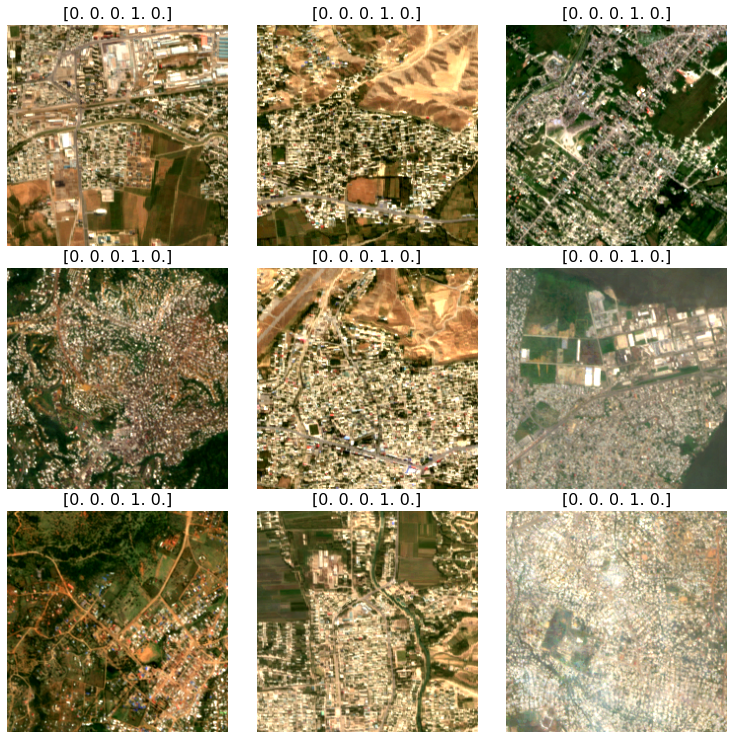

In [78]:
sat_var = "b_rgb"
display_9_images_from_dataset(load_dataset(training_filenames, sat_var, exp_det = False, train = False))

## Run CNN

In [79]:
# If False, loads previously processed model and creates (a) features and (b)
# predictions datasets 
RUN_MODEL = False
MAKE_DATASETS = True

overwrite_model = False # Whether to overwrite model if already exists

for sat_var in ['b_rgb', 'b_ndvi', 'b_bu']: # 'b_rgb', 'b_ndvi', 'b_bu'
  
    print(sat_var + ' ----------------------------------------------------------')

    # 1. PREP AND RUN MODEL ========================================================

    # Instantiate the datasets -----------------------------------------------------
    training_dataset = get_batched_dataset(training_filenames, sat_var, exp_det = False, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, sat_var, exp_det = False, train=False)

    validation_dataset_exdtT = get_batched_dataset(validation_filenames, sat_var, exp_det = True, train=False)
    all_dataset_exdtT = get_batched_dataset(all_filenames, sat_var, exp_det = True, train=False)

    # Split all_dataset into chunks ----------------------------------------------
    # We max out RAM when trying to get full dataset of all features, so break into chunks
    n_group = math.ceil(len(all_filenames)/15)

    all_filenames_list = list(divide_chunks(all_filenames, n_group))

    all_filenames_0 = all_filenames_list[0]
    all_filenames_1 = all_filenames_list[1]
    all_filenames_2 = all_filenames_list[2]
    all_filenames_3 = all_filenames_list[3]
    all_filenames_4 = all_filenames_list[4]
    all_filenames_5 = all_filenames_list[5]
    all_filenames_6 = all_filenames_list[6]
    all_filenames_7 = all_filenames_list[7]
    all_filenames_8 = all_filenames_list[8]
    all_filenames_9 = all_filenames_list[9]
    all_filenames_10 = all_filenames_list[10]
    all_filenames_11 = all_filenames_list[11]
    all_filenames_12 = all_filenames_list[12]
    all_filenames_13 = all_filenames_list[13]
    all_filenames_14 = all_filenames_list[14]

    all_dataset_0_exdtT = get_batched_dataset(all_filenames_0, sat_var, exp_det = True, train=False)
    all_dataset_1_exdtT = get_batched_dataset(all_filenames_1, sat_var, exp_det = True, train=False)
    all_dataset_2_exdtT = get_batched_dataset(all_filenames_2, sat_var, exp_det = True, train=False)
    all_dataset_3_exdtT = get_batched_dataset(all_filenames_3, sat_var, exp_det = True, train=False)
    all_dataset_4_exdtT = get_batched_dataset(all_filenames_4, sat_var, exp_det = True, train=False)
    all_dataset_5_exdtT = get_batched_dataset(all_filenames_5, sat_var, exp_det = True, train=False)
    all_dataset_6_exdtT = get_batched_dataset(all_filenames_6, sat_var, exp_det = True, train=False)
    all_dataset_7_exdtT = get_batched_dataset(all_filenames_7, sat_var, exp_det = True, train=False)
    all_dataset_8_exdtT = get_batched_dataset(all_filenames_8, sat_var, exp_det = True, train=False)
    all_dataset_9_exdtT = get_batched_dataset(all_filenames_9, sat_var, exp_det = True, train=False)
    all_dataset_10_exdtT = get_batched_dataset(all_filenames_10, sat_var, exp_det = True, train=False)
    all_dataset_11_exdtT = get_batched_dataset(all_filenames_11, sat_var, exp_det = True, train=False)
    all_dataset_12_exdtT = get_batched_dataset(all_filenames_12, sat_var, exp_det = True, train=False)
    all_dataset_13_exdtT = get_batched_dataset(all_filenames_13, sat_var, exp_det = True, train=False)
    all_dataset_14_exdtT = get_batched_dataset(all_filenames_14, sat_var, exp_det = True, train=False)

    # Output names -----------------------------------------------------------------
    # Paths for saving model, predictions (on test) and featurs (on training)
    name_suffix = OUT_NAME_SUFFIX + "_" + sat_var

    CNN_MODEL_PATH = os.path.join(cf.DROPBOX_DIRECTORY, 'Data', SURVEY_NAME, 'FinalData',
                                    'cnn_models', 
                                    'model_' + name_suffix + '.h5')

    PREDICTIONS_PATH = os.path.join(cf.DROPBOX_DIRECTORY, 'Data', SURVEY_NAME, 'FinalData', "Individual Datasets",
                                    'cnn_predictions',
                                    'predictions_' + name_suffix + '.csv')

    FEATURES_PATH = os.path.join(cf.DROPBOX_DIRECTORY, 'Data', SURVEY_NAME, 'FinalData', "Individual Datasets",
                                    'cnn_features', "split_into_data_subsets",
                                    'features_' + name_suffix)

    # Define model ---------------------------------------------------------------
    if (RUN_MODEL & ((os.path.exists(CNN_MODEL_PATH) == False | overwrite_model))): 
        ### Setup Pre-Trained Network
        #pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
        pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
        #pretrained_model = tf.keras.applications.ResNet18(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
        #pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
        pretrained_model.trainable = False

        ### Setup Model
        model = tf.keras.Sequential([
            pretrained_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(4096, activation='relu', name = 'fc1'), # 512, 4096
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_GROUPS, activation='softmax')
        ])

        model.compile(
            optimizer='rmsprop', # adam
            loss = 'categorical_crossentropy',
            metrics=['accuracy']
        )

        model.summary()

        # Run model --------------------------------------------------------------------
        ### Setup Early Stopping
        # Use early stopping to help with overfitting
        monitor = 'val_accuracy'
        mode = 'max'
        es = EarlyStopping(monitor=monitor, mode=mode, patience=PATIENCE, verbose=False)

        mc = ModelCheckpoint(CNN_MODEL_PATH, monitor=monitor, mode=mode, 
                            verbose=True, save_best_only=True)

        ### Fit Model
        history = model.fit(training_dataset, 
                            steps_per_epoch=steps_per_epoch, 
                            epochs=EPOCHS,
                            callbacks=[es, mc],
                            validation_data=validation_dataset, 
                            validation_steps=validation_steps)

        # Show history -----------------------------------------------------------------
        print(history.history.keys())
        display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
        display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

    # 2. EXTRACT FEATURES AND PREDICTIONS ==========================================
    if MAKE_DATASETS:

        ## Load model ------------------------------------------------------------------
        model = load_model(CNN_MODEL_PATH)

        ## Double check evaluation -----------------------------------------------------
        if False:
            print("Check validation accuracy")
            model.evaluate(validation_dataset_exdtT) 

        ## Grab features ---------------------------------------------------------------
        print("Extract features")
        feature_extractor = Model(inputs=model.inputs,
                        outputs=model.get_layer(name='fc1').output,)

        def extract_features(all_dataset_i_exdtT, all_filenames_i, i, FEATURES_PATH):
            print(i)

            features_i = feature_extractor.predict(all_dataset_i_exdtT)
            features_i_df = pd.DataFrame(features_i).add_prefix('cnn_feat_')
            features_i_df['uid'] = dataset_to_numpy_util_single_val(load_dataset_uid(all_filenames_i, exp_det = True),features_i_df.shape[0])
            features_i_df.to_csv(FEATURES_PATH + '_' + str(i) + '.csv', index=False)

        extract_features(all_dataset_0_exdtT, all_filenames_0, 0, FEATURES_PATH)
        extract_features(all_dataset_1_exdtT, all_filenames_1, 1, FEATURES_PATH)
        extract_features(all_dataset_2_exdtT, all_filenames_2, 2, FEATURES_PATH)
        extract_features(all_dataset_3_exdtT, all_filenames_3, 3, FEATURES_PATH)
        extract_features(all_dataset_4_exdtT, all_filenames_4, 4, FEATURES_PATH)
        extract_features(all_dataset_5_exdtT, all_filenames_5, 5, FEATURES_PATH)
        extract_features(all_dataset_6_exdtT, all_filenames_6, 6, FEATURES_PATH)
        extract_features(all_dataset_7_exdtT, all_filenames_7, 7, FEATURES_PATH)
        extract_features(all_dataset_8_exdtT, all_filenames_8, 8, FEATURES_PATH)
        extract_features(all_dataset_9_exdtT, all_filenames_9, 9, FEATURES_PATH)
        extract_features(all_dataset_10_exdtT, all_filenames_10, 10, FEATURES_PATH)
        extract_features(all_dataset_11_exdtT, all_filenames_11, 11, FEATURES_PATH)
        extract_features(all_dataset_12_exdtT, all_filenames_12, 12, FEATURES_PATH)
        extract_features(all_dataset_13_exdtT, all_filenames_13, 13, FEATURES_PATH)
        extract_features(all_dataset_14_exdtT, all_filenames_14, 14, FEATURES_PATH)

        #feature_extractor = Model(inputs=model.inputs,
        #                  outputs=model.get_layer(name='fc1').output,)

        #features = feature_extractor.predict(all_dataset_exdtT)
        #features_df = pd.DataFrame(features).add_prefix('cnn_feat_')

        #features_df['uid'] = dataset_to_numpy_util_single_val(load_dataset_uid(all_filenames, exp_det = True),features_df.shape[0])

        #features_df.to_csv(FEATURES_PATH, index=False)

        ## Grab predicted value --------------------------------------------------------
        print("Grab predicted value")
        predictions = model.predict(validation_dataset_exdtT)
        predictions = predictions.argmax(axis=-1)

        true_values = dataset_to_numpy_util_single_val(load_dataset_ntl_group(validation_filenames, exp_det = True),predictions.shape[0])
        true_values = true_values.argmax(axis=-1)

        pred_df = pd.DataFrame({'predictions':predictions, 'true_values':true_values})
        pred_df['uid'] = dataset_to_numpy_util_single_val(load_dataset_uid(validation_filenames, exp_det = True),predictions.shape[0])

        pred_df.to_csv(PREDICTIONS_PATH, index=False)

        # Check predicted values -------------------------------------------------------
        print("Check predicted values")
        print(np.mean(pred_df['predictions'] == pred_df['true_values']))

b_rgb ----------------------------------------------------------
Extract features
0
276/276 [==============================] - 23s 81ms/step
1
272/272 [==============================] - 23s 84ms/step
2
270/270 [==============================] - 23s 87ms/step
3
324/324 [==============================] - 29s 89ms/step
4
253/253 [==============================] - 22s 87ms/step
5
226/226 [==============================] - 20s 91ms/step
6
233/233 [==============================] - 20s 87ms/step
7
278/278 [==============================] - 25s 89ms/step
8
255/255 [==============================] - 22s 87ms/step
9
263/263 [==============================] - 23s 87ms/step
10
247/247 [==============================] - 22s 91ms/step
11
267/267 [==============================] - 24s 91ms/step
12
283/283 [==============================] - 25s 88ms/step
13
272/272 [==============================] - 24s 88ms/step
14
280/280 [==============================] - 25s 89ms/step
Grab predicted value
202/202